# Normalization (归一化) 
## 为什么需要Normalization? 

1. 归一化的数据处理能将参数数量级统一。在训练过程中，中间层变量可能会有更广的变化范围；不论是沿着从输入到输出的层，同层中不同单元，或者沿时间不同的Batch、Epoch，模型参数都会变幻莫测。这种中间层变量分布的偏移，可能会妨碍网络收敛（有些变量变的特别大，有些变量特别小会导致相同学习率，可变值差异太大）。 直观方案：自适应调整每一层的学习率，或者神经元激活值归一化。使用归一化能够提高网路收敛性和速度。
2. 深层网络复杂度高，容易过拟合，正则化非常重要。

注意：BN只是一种技术，没有经过严谨证明，没有一个有效的解释

## 什么是Normalization:
    
归一化就是样本减去样本均值，除以标准差，再进行线性变化（拉伸和平移）。不同的Normalization的区别主要在于操作的Feature map维度：
$$ 卷积: x ∈ R^{N \times C \times H \times W} $$
$$ 全连接: x ∈ R^{N \times D}$$
$$ N(x) = \gamma( \frac{x - \mu(x)} {\sigma(x)} ) + \beta $$

注意：BN在训练和预测中计算不同。（预测只用训练过程中计算好的移动平均均值和方差）

## 一、BN(Batch Normalization)
$$ BN(x) = \gamma( \frac{x - \mu(x)} {\sigma(x)} ) + \beta $$

BN是对一个**Batch**中的样本进行归一化；

**卷积层情况:** $ x ∈ R^{N \times C \times H \times W}$ ,BN保留通道维度(各通道单独处理，通道内部共享均值方差)，将 N 个样本第 i 个通道累加并求平均，得到这个Batch在通道 i 上的均值（标量，而非矩阵）。方差也是同理。具体公式如下:


$$ \mu_c(x) = \frac{1}{NHW} \sum_{n=1}^{N}\sum_{h=1}^{H}\sum_{w=1}^{W} x_{nchw} $$
$$ \sigma_c(x) = \sqrt{\frac{1}{NHW} \sum_{n=1}^{N}\sum_{h=1}^{H}\sum_{w=1}^{W} (x_{nchw} - \mu_c(x))^2 + \epsilon } $$


**全连接层情况:** $ x ∈ R^{N \times D}$ ,各神经元之间不共享均值方差，在神经元维度上进行样本特征均值方差的求解。


$$ \mu_d(x) = \frac{1}{N} \sum_{n=1}^{N} x_{nd} $$
$$ \sigma_d(x) = \sqrt{\frac{1}{N} \sum_{n=1}^{N} (x_{nd} - \mu_d(x))^2 + \epsilon } $$

方差估计值中添加一个小常量 $\epsilon > 0$，来确保永远不会除以零。

BN中Batch size的选择很重要，Batch size太小是无法合理预估训练数据的均值和方差的（样本数量不够），并且，如果Batch-size = 1， 减去均值就变成了0；但是Batch size太大会导致显存不够用。

$ \color{Red} BN与激活函数以及Bias$ ：
BN要加载激活函数之前，且如果卷积层后接BN，可以不设置bias。

## 二、LN(Layer Normalization)


## GN 


In [ ]:
import matplotlib.pyplot as plt
import torch
import math
import torch.nn.functional as F
import numpy as np
from torch import nn
from torchvision import transforms
from PIL import Image


# 实现一个BN
# X: 输入样本数据 
# gamma 放缩系数
# beta 偏置系数
# moving_mean 移动平均均值
# moving_Var 移动平均方差
# eps 常量因子
# momentum 动量
def Batch_norm(X, gamma,beta,moving_mean,moving_var, eps, momentum):
    # 判断当前torch模式
    if not torch.is_grad_enabled():
        # 预测模式
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        # 确保当前数据是全连接/卷积 shape
        assert len(X.shape) in (2,4)
        # 全连接
        if(X.shape == 2):
            # 特征维度(dim = 1)均值，算出每个特征的均值
            mean =  X.mean(dim = 0)
            var = ((X -mean) **2).mean(dim = 0)
        else:
            # 卷积层情况,在dim =1(通道)上计算均值方差
            mean = X.mean(dim = (0,2,3),keepdim = True)
            var = ((X -mean)**2).mean(dim = (0,2,3),keepdim = True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum)*mean
        moving_var = momentum*var + (1.0  - momentum)*var
    # 线性变换
    Y = gamma * X_hat + beta 
    return Y, moving_mean.data,moving_var.data



class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [ ]:
# Lenet使用BN

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

In [109]:

# 填充成正方形
class SquarePad:
	def __call__(self, image):
		_, w, h = image.shape
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
        # 上 下 左 右
		padding =  (vp, vp, hp, hp)
		return F.pad(image, padding, 'constant')

# 展示原图和处理后的图片
def show_imgs(imgs,num_cols,scale = 1.5):
    num = len(imgs)
    num_rows = int(math.ceil(num / num_cols))
    plt.figure(num_rows*num_cols*scale)
    axes  = []
    for i in range(len(imgs)):
        axe = plt.subplot(num_rows, num_cols,i+1)
        axes.append(axe)

    for axe,img in zip(axes,imgs):
        if torch.is_tensor(img):
            axe.imshow(img.permute(1,2,0).numpy())
        else:
            axe.imshow(img)


<class 'PIL.JpegImagePlugin.JpegImageFile'> (1920, 1080)
torch.Size([1, 55, 55])
torch.Size([1, 55, 55])
torch.Size([1, 27, 27])
torch.Size([1, 27, 27])
torch.Size([1, 27, 27])
torch.Size([1, 13, 13])
torch.Size([1, 13, 13])
torch.Size([1, 13, 13])
torch.Size([1, 13, 13])
torch.Size([1, 13, 13])
torch.Size([1, 13, 13])
torch.Size([1, 13, 13])
torch.Size([1, 6, 6])
torch.Size([1, 6, 6])
torch.Size([1, 6, 6])


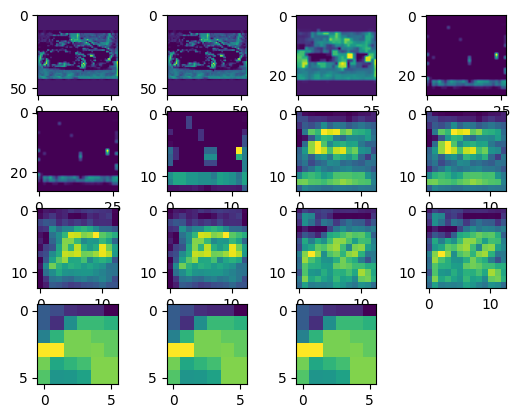

In [137]:
from torchvision import models

net = models.AlexNet()

img = Image.open('./img/Example.jpg')

print(type(img), img.size)

trans = transforms.Compose([
    transforms.ToTensor(),
    SquarePad(),
    transforms.Resize((224,224))
])
X = trans(img)

X = torch.unsqueeze(X,0)

mid_results = []
layer_types  = [nn.Conv2d,nn.ReLU,nn.MaxPool2d]

with torch.no_grad():
    for layer in net.children():
        if type(layer) in layer_types:
            X = layer(X)
            mid_results.append(X)
        elif type(layer) == nn.Sequential:
            for layer2 in layer:
                if type(layer2) in layer_types:
                    X = layer2(X)
                    mid_results.append(X)

# with torch.no_grad():
#     for layer in net.children():
#         if type(layer) in layer_types:
#             X = layer(X)
#             # mid_results.append(X)
#         elif type(layer) == nn.BatchNorm2d:
#             Y = layer(X)
#             mid_results.append((X,Y))
#             print(X.shape,Y.shape)
#             X = Y
#         elif type(layer) == nn.Sequential:
#             for layer2 in layer:
#                 if type(layer2) in layer_types:
#                     X = layer2(X)
#                     # mid_results.append(X)
#                 elif type(layer2) == nn.BatchNorm2d:
#                     Y = layer2(X)
#                     mid_results.append((X,Y))
#                     print(X.shape,Y.shape)
#                     X = Y


feature_maps = []
for mid_result in mid_results:
    feature_map = torch.unsqueeze(mid_result.squeeze(0)[0],0)
    print(feature_map.shape)
    feature_maps.append(feature_map)

# for mid_result,mid_result_bn in mid_results:
#     feature_map = torch.unsqueeze(mid_result.squeeze(0)[0],0)
#     feature_map_bn = torch.unsqueeze(mid_result_bn.squeeze(0)[0],0)
#     feature_maps.append(feature_map)
#     feature_maps.append(feature_map_bn)

show_imgs(feature_maps,4,scale = 100)

# show_imgs(feature_maps,2)